In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.stats import gaussian_kde


from result_analysis.helper_functions import (
  process_csv_data,
  get_numeric_features
)

plt.set_cmap('viridis')
plt.rcParams.update({'font.size': 14})

<Figure size 640x480 with 0 Axes>

In [3]:
reduced_set = process_csv_data("/home/csoare/experiments/reduced_instances_final/features.csv")
horn_set = process_csv_data("/home/csoare/experiments/reduced_instances_final/horn_features.csv")

features = pd.concat([reduced_set, horn_set])

# Total instances
total_instances = len(features)

# Display statistics
print(f"Total number of instances: {total_instances}")
# Print number of instances per generator
instances_per_generator = features['generator'].value_counts()
print("Number of instances per generator:")
print(instances_per_generator)

Total number of instances: 1404
Number of instances per generator:
generator
PairSATHORN-easy-100    101
FuzzSATHORN-hard-100    101
FuzzSATHORN-easy-100    101
PairSATHORN-hard-100    101
FuzzSAT-easy-0          100
FuzzSAT-easy-100        100
FuzzSAT-hard-50         100
FuzzSAT-hard-100        100
FuzzSAT-hard-0          100
FuzzSAT-easy-50         100
PairSAT-easy-100        100
PairSAT-easy-0          100
PairSAT-hard-100        100
PairSAT-hard-0          100
Name: count, dtype: int64


In [4]:
# Verify the new columns
print("\nUnique presumed difficulties:", features['presumed_difficulty'].unique())
print("Unique randomness values:", features['randomness'].unique())


Unique presumed difficulties: ['easy' 'hard']
Unique randomness values: [  0 100  50]


In [5]:
get_numeric_features(features)

['nvarsOrig',
 'nclausesOrig',
 'nvars',
 'nclauses',
 'reducedVars',
 'reducedClauses',
 'vars-clauses-ratio',
 'POSNEG-RATIO-CLAUSE-mean',
 'POSNEG-RATIO-CLAUSE-coeff-variation',
 'POSNEG-RATIO-CLAUSE-min',
 'POSNEG-RATIO-CLAUSE-max',
 'POSNEG-RATIO-CLAUSE-entropy',
 'VCG-CLAUSE-mean',
 'VCG-CLAUSE-coeff-variation',
 'VCG-CLAUSE-min',
 'VCG-CLAUSE-max',
 'VCG-CLAUSE-entropy',
 'UNARY',
 'BINARY+',
 'TRINARY+',
 'VCG-VAR-mean',
 'VCG-VAR-coeff-variation',
 'VCG-VAR-min',
 'VCG-VAR-max',
 'VCG-VAR-entropy',
 'POSNEG-RATIO-VAR-mean',
 'POSNEG-RATIO-VAR-stdev',
 'POSNEG-RATIO-VAR-min',
 'POSNEG-RATIO-VAR-max',
 'POSNEG-RATIO-VAR-entropy',
 'HORNY-VAR-mean',
 'HORNY-VAR-coeff-variation',
 'HORNY-VAR-min',
 'HORNY-VAR-max',
 'HORNY-VAR-entropy',
 'horn-clauses-fraction',
 'VG-mean',
 'VG-coeff-variation',
 'VG-min',
 'VG-max',
 'CG-mean',
 'CG-coeff-variation',
 'CG-min',
 'CG-max',
 'CG-entropy',
 'cluster-coeff-mean',
 'cluster-coeff-coeff-variation',
 'cluster-coeff-min',
 'cluster-coef

In [6]:
feature_categories = {
   'Problem Size': ['nvars', 'nclauses', 'vars-clauses-ratio', 'nvarsOrig', 'nclausesOrig'],
   'Variable-Clause Graph': ['VCG-VAR-mean', 'VCG-VAR-coeff-variation', 'VCG-VAR-min', 'VCG-VAR-max', 'VCG-VAR-entropy', 
                             'VCG-CLAUSE-mean', 'VCG-CLAUSE-coeff-variation', 'VCG-CLAUSE-min', 'VCG-CLAUSE-max', 'VCG-CLAUSE-entropy'],
   'Variable Graph': ['VG-mean', 'VG-coeff-variation', 'VG-min', 'VG-max'],
   'Clause Graph': ['CG-mean', 'CG-coeff-variation', 'CG-min', 'CG-max', 'CG-entropy',
                    'cluster-coeff-mean', 'cluster-coeff-coeff-variation', 'cluster-coeff-min', 'cluster-coeff-max', 'cluster-coeff-entropy'],
   'Balance': ['POSNEG-RATIO-CLAUSE-mean', 'POSNEG-RATIO-CLAUSE-coeff-variation', 'POSNEG-RATIO-CLAUSE-min', 'POSNEG-RATIO-CLAUSE-max', 'POSNEG-RATIO-CLAUSE-entropy',
              'POSNEG-RATIO-VAR-mean', 'POSNEG-RATIO-VAR-stdev', 'POSNEG-RATIO-VAR-min', 'POSNEG-RATIO-VAR-max', 'POSNEG-RATIO-VAR-entropy',
              'UNARY', 'BINARY+', 'TRINARY+'],
   'Horn Formula': ['horn-clauses-fraction', 'HORNY-VAR-mean', 'HORNY-VAR-coeff-variation', 'HORNY-VAR-min', 'HORNY-VAR-max', 'HORNY-VAR-entropy'],
   'Other Features': ['Pre-featuretime', 'Basic-featuretime', 'KLB-featuretime', 'CG-featuretime', 'solved', 'generator', 'seed', 'base_generator', 'presumed_difficulty', 'randomness']
}


In [7]:
def plot_features_comparison(df, category, group_1, group_2, n_cols, dict={}):
    """
    Generates detailed feature distribution plots for analyzing SAT instance characteristics.
    
    Args remain the same as original function.
    New layout: Legend occupies the last slot in the final row of plots.
    """
    plt.rcParams.update({
        'axes.labelsize': 32,
        'xtick.labelsize': 28,
        'ytick.labelsize': 28
    })
    
    features = feature_categories[category]
    
    pos_val1 = df[group_1].unique()
    pos_val2 = df[group_2].unique()
    
    if dict.get(group_1) is not None:
        pos_val1 = [dict[group_1]]
    if dict.get(group_2) is not None:
        pos_val2 = [dict[group_2]]
        
    for val1 in pos_val1:
        for val2 in pos_val2:
            data = df[(df[group_1] == val1) & (df[group_2] == val2)]
            
            legend_var = [x for x in ['base_generator', 'presumed_difficulty', 'randomness'] 
                        if x not in [group_1, group_2]][0]
            n_rows = (len(features) + n_cols - 1) // n_cols
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6*n_rows))
            
            group_1_label = f'{group_1}: {val1}'
            group_2_label = f'{group_2}: {val2}'
            
            # Center the title
            fig.suptitle(f'{category} Features - {group_1_label}, {group_2_label}', 
                        y=1.02, fontsize=48, ha='center')
            
            legend_handles, legend_labels = [], []
            axes = np.array(axes).reshape(n_rows, n_cols)
            plt.subplots_adjust(top=0.8, bottom=0.15, hspace=0.9, wspace=0.4)
            
            for idx, feature in enumerate(features):
                row, col = idx // n_cols, idx % n_cols
                ax = axes[row, col]
                
                max_density = 0
                sorted_vals = sorted(data[legend_var].unique())
                for val in sorted_vals:
                    subset = data[data[legend_var] == val][feature]
                    try:
                        density = gaussian_kde(subset)
                        xs = np.linspace(subset.min(), subset.max(), 200)
                        max_density = max(max_density, np.max(density(xs)))
                    except:
                        counts, _ = np.histogram(subset, bins=20, density=True)
                        max_density = max(max_density, np.max(counts))
                
                colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_vals)))
                for val, color in zip(sorted_vals, colors):
                    subset = data[data[legend_var] == val][feature]
                    h = None
                    try:
                        density = gaussian_kde(subset)
                        xs = np.linspace(subset.min(), subset.max(), 200)
                        ys = density(xs) / max_density
                        h = ax.plot(xs, ys, color=color)[0]
                        ax.fill_between(xs, ys, color=color, alpha=0.2)
                    except:
                        counts, bins = np.histogram(subset, bins=20, density=True)
                        counts = counts / max_density
                        centers = (bins[:-1] + bins[1:]) / 2
                        width = np.diff(bins)
                        h = ax.bar(centers, counts, width=width, alpha=0.5, color=color)
                    finally:
                        if idx == 0:
                            legend_handles.append(h)
                            legend_labels.append(f'{val}' + ('%' if legend_var == 'randomness' else ''))
                
                ax.set_title(feature, pad=20)
                if col == 0:
                    ax.set_ylabel('Density')
                else:
                    ax.set_yticks([])
                if row == n_rows - 1:
                    ax.set_xlabel('Value')
            
            # Turn off all remaining axes except the last one (which will be used for legend)
            for idx in range(len(features), n_rows * n_cols - 1):
                axes[idx // n_cols, idx % n_cols].axis('off')
            
            # Use the last subplot for the legend
            last_ax = axes[-1, -1]
            last_ax.axis('off')
            legend = last_ax.legend(legend_handles, legend_labels,
                                  loc='center',
                                  fontsize=44)
            last_ax.add_artist(legend)
            
            plt.tight_layout()
            plt.show()
            plt.close()

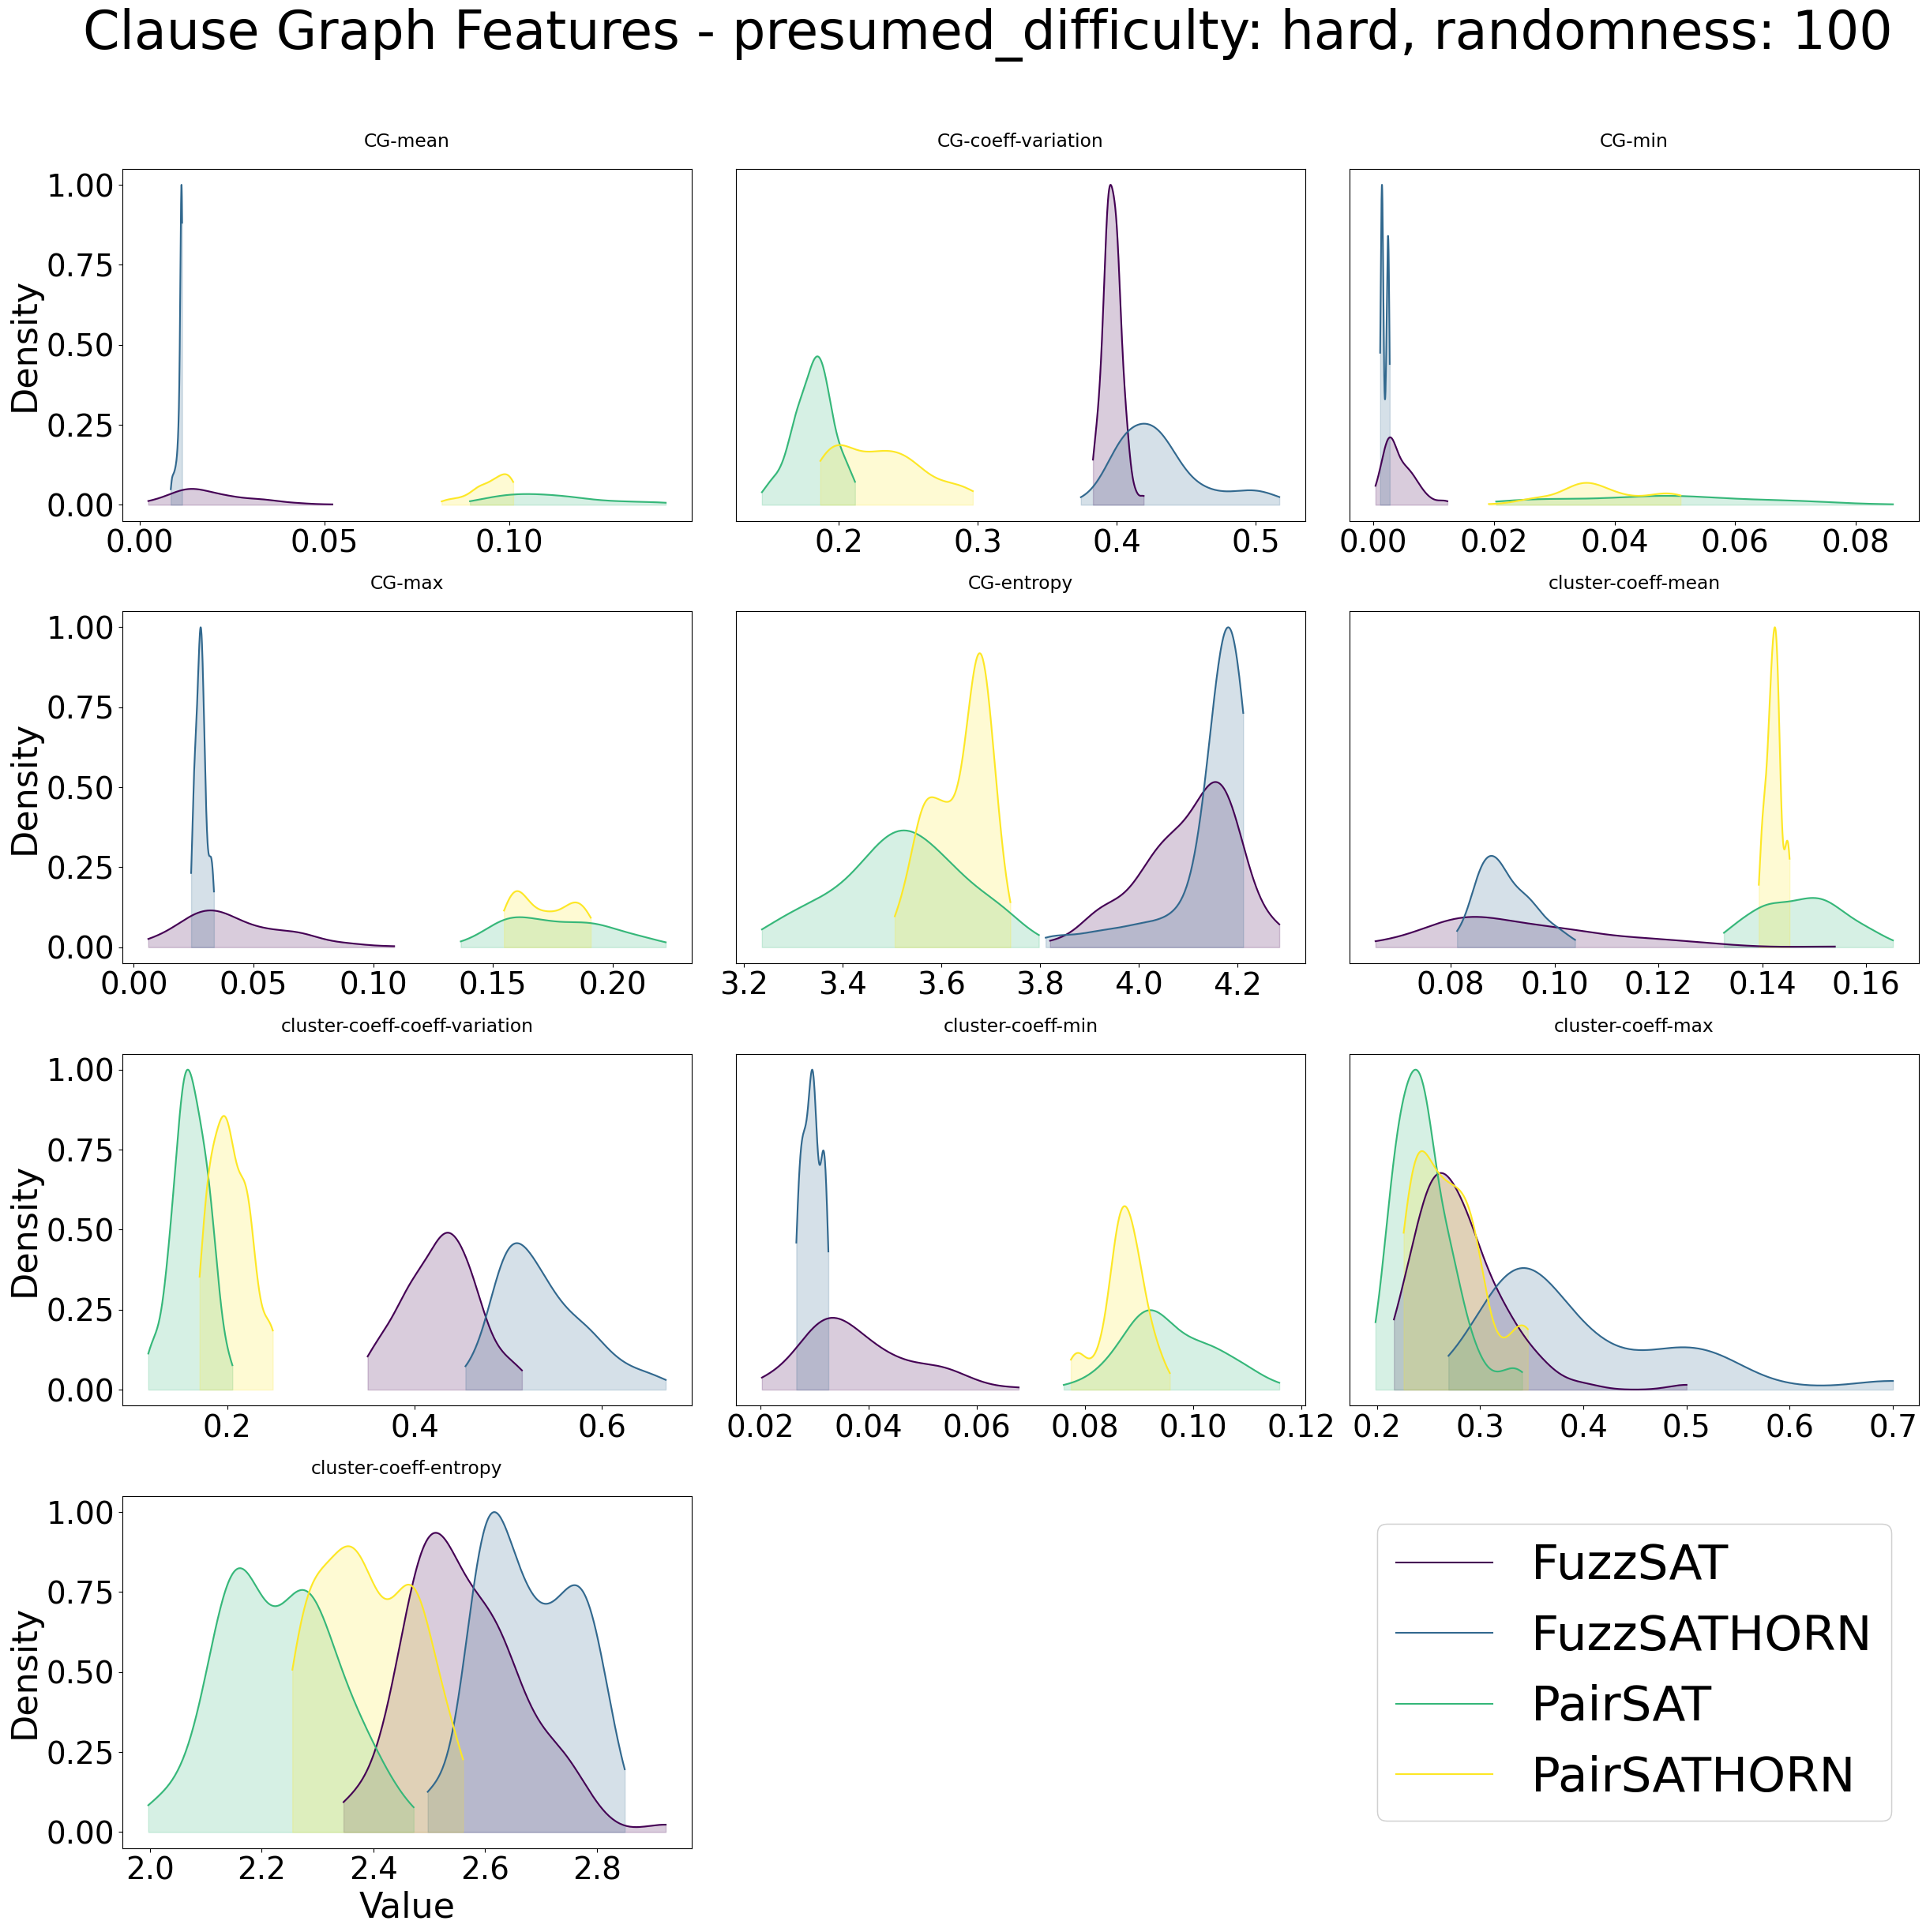

In [8]:
category = 'Clause Graph'

# plot_features_comparison(features, category, 'base_generator', 'presumed_difficulty', 4)
# plot_features_comparison(features, category, 'base_generator', 'randomness', 4)

plot_features_comparison(features, category, 'presumed_difficulty', 'randomness', 3, {'presumed_difficulty': 'hard', 'randomness': 100})

/tmp/ipykernel_194519/183175459.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis', len(combined_data))


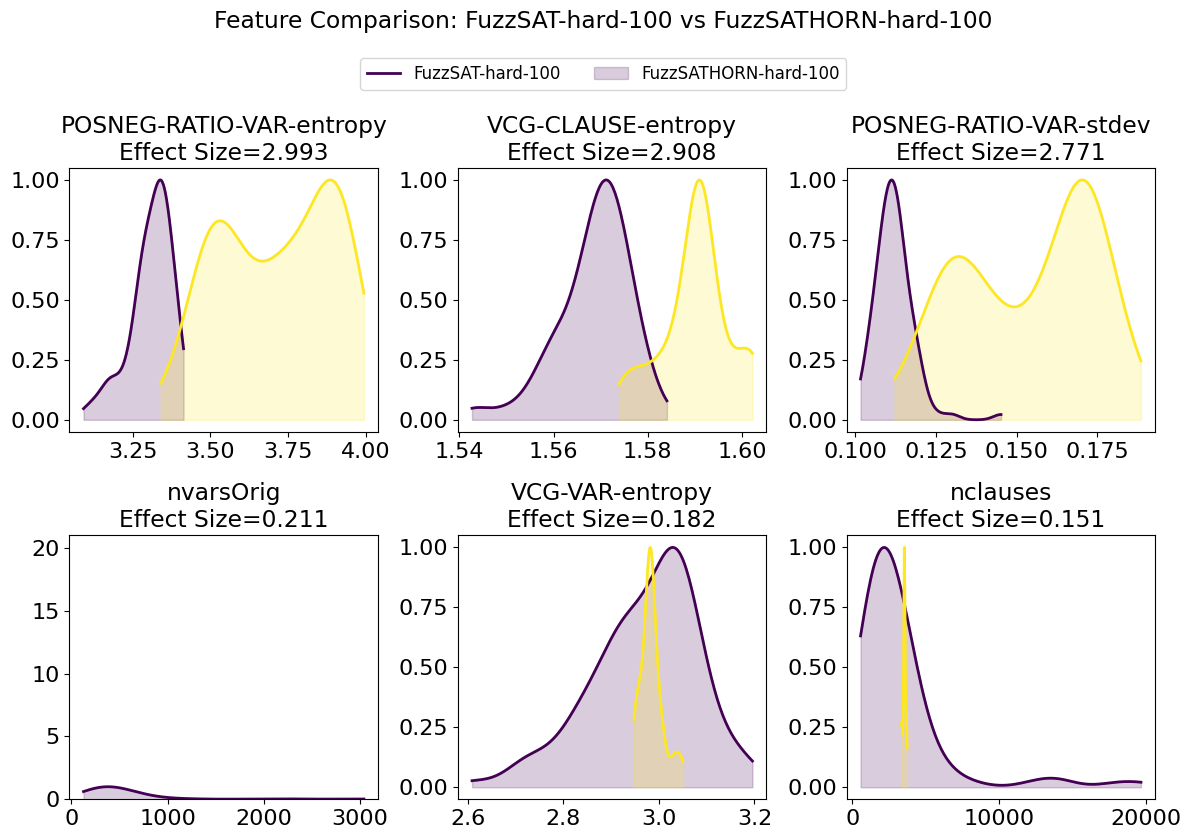

{'top': [('POSNEG-RATIO-VAR-entropy', np.float64(2.99307926255885)),
  ('VCG-CLAUSE-entropy', np.float64(2.9079727572384364)),
  ('POSNEG-RATIO-VAR-stdev', np.float64(2.770536315162662))],
 'bottom': [('nvarsOrig', np.float64(0.21063234418619445)),
  ('VCG-VAR-entropy', np.float64(0.18249724329847308)),
  ('nclauses', np.float64(0.15108407728807885))]}

In [13]:

plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16
})

def compare_two_generators(df, gen1, gen2, n=5):
    """
    Compare features between two specified generators.

    Parameters:
    - df: DataFrame containing the data.
    - gen1: Name of the first generator to compare.
    - gen2: Name of the second generator to compare.
    - n: Number of top and bottom features to display (default: 5).

    Returns:
    - Dictionary with top and bottom features by effect size.
    """
    features = get_numeric_features(df)
    results = {}
    
    # Filter data for the two generators
    data1 = df[df['generator'] == gen1]
    data2 = df[df['generator'] == gen2]
    
    if data1.empty or data2.empty:
        raise ValueError(f"One or both generators ({gen1}, {gen2}) do not exist in the data.")
    
    combined_data = {gen1: data1, gen2: data2}
    
    # Calculate effect sizes
    effect_sizes = {}
    for feature in features:
        try:
            has_variation = any(data[feature].nunique() > 1 for data in combined_data.values())
            
            if has_variation:
                pooled_var = np.mean([data[feature].var() for data in combined_data.values()])
                means = [data[feature].mean() for data in combined_data.values()]
                max_diff = max(means) - min(means)
                d = max_diff / np.sqrt(pooled_var)
                if not np.isnan(d):
                    effect_sizes[feature] = abs(d)
        except Exception:
            continue
    
    if not effect_sizes:
        print("No significant differences found between the two generators.")
        return
    
    sorted_effects = sorted(effect_sizes.items(), key=lambda x: abs(x[1]), reverse=True)
    top_diff = sorted_effects[:n]
    bottom_diff = sorted_effects[-n:]
    results = {'top': top_diff, 'bottom': bottom_diff}
    
    # Plot results
    fig, axes = plt.subplots(2, n, figsize=(4*n, 8))
    colormap = cm.get_cmap('viridis', len(combined_data))
    colors = colormap(range(len(combined_data)))
    
    # Plot top differences
    for i, (feature, effect) in enumerate(top_diff):
        for idx, (group, data) in enumerate(combined_data.items()):
            try:
                density = gaussian_kde(data[feature])
                xs = np.linspace(data[feature].min(), data[feature].max(), 200)
                ys = density(xs)
                ys = ys / np.max(ys)
                line = axes[0, i].plot(xs, ys, label=group, linewidth=2, color=colors[idx])
                axes[0, i].fill_between(xs, ys, alpha=0.2, color=colors[idx])
            except:
                # Fallback to histogram
                axes[0, i].hist(data[feature], bins=20, alpha=0.6, label=group, density=True, color=colors[idx])
        
        axes[0, i].set_title(f'{feature}\nEffect Size={effect:.3f}')
    
    # Plot bottom differences
    for i, (feature, effect) in enumerate(bottom_diff):
        for idx, (group, data) in enumerate(combined_data.items()):
            try:
                density = gaussian_kde(data[feature])
                xs = np.linspace(data[feature].min(), data[feature].max(), 200)
                ys = density(xs)
                ys = ys / np.max(ys)
                axes[1, i].plot(xs, ys, label=group, linewidth=2, color=colors[idx])
                axes[1, i].fill_between(xs, ys, alpha=0.2, color=colors[idx])
            except:
                # Fallback to histogram
                axes[1, i].hist(data[feature], bins=20, alpha=0.6, label=group, density=True, color=colors[idx])
        
        axes[1, i].set_title(f'{feature}\nEffect Size={effect:.3f}')
    
    plt.suptitle(f'Feature Comparison: {gen1} vs {gen2}', y=1.05)
    plt.figlegend(labels=combined_data.keys(), loc='upper center',
                  bbox_to_anchor=(0.5, 1.0), bbox_transform=plt.gcf().transFigure,
                  ncol=2, fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return results

compare_two_generators(features, 'FuzzSAT-hard-100', 'FuzzSATHORN-hard-100', n=3)